In [1]:
import math
import numpy as np
import scipy.sparse as sp
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import os
import numpy as np
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from box import Box

import warnings

warnings.filterwarnings(action='ignore')
torch.set_printoptions(sci_mode=True)

# 1. 학습 설정

In [2]:
config = {
    'data_path' : "/opt/ml/input/data/train" , # 데이터 경로
    'model_path' : "../model",


    'submission_path' : "../submission",
    'submission_name' : 'Ensemble_v16_submission.csv',

    'candidate_item_num' : 50,
    'valid_samples' : 10, # 검증에 사용할 sample 수
    'seed' : 22,
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

config = Box(config)

# 2. 데이터 전처리

In [3]:
class MakeMatrixDataSet():
    """
    MatrixDataSet 생성
    """
    def __init__(self, config):
        self.config = config
        self.df = pd.read_csv(os.path.join(self.config.data_path, 'train_ratings.csv'))
        
        self.item_encoder, self.item_decoder = self.generate_encoder_decoder('item')
        self.user_encoder, self.user_decoder = self.generate_encoder_decoder('user')
        self.num_item, self.num_user = len(self.item_encoder), len(self.user_encoder)

        self.df['item_idx'] = self.df['item'].apply(lambda x : self.item_encoder[x])
        self.df['user_idx'] = self.df['user'].apply(lambda x : self.user_encoder[x])

        self.user_train, self.user_valid = self.generate_sequence_data()

    def generate_encoder_decoder(self, col : str) -> dict:
        """
        encoder, decoder 생성

        Args:
            col (str): 생성할 columns 명
        Returns:
            dict: 생성된 user encoder, decoder
        """

        encoder = {}
        decoder = {}
        ids = self.df[col].unique()

        for idx, _id in enumerate(ids):
            encoder[_id] = idx
            decoder[idx] = _id

        return encoder, decoder
    
    def generate_sequence_data(self) -> dict:
        """
        sequence_data 생성

        Returns:
            dict: train user sequence / valid user sequence
        """
        users = defaultdict(list)
        user_train = {}
        user_valid = {}
        for user, item, time in zip(self.df['user_idx'], self.df['item_idx'], self.df['time']):
            users[user].append(item)
        
        for user in users:
            np.random.seed(self.config.seed)

            user_total = users[user]
            valid = np.random.choice(user_total, size = self.config.valid_samples, replace = False).tolist()
            train = list(set(user_total) - set(valid))

            user_train[user] = train
            user_valid[user] = valid # valid_samples 개수 만큼 검증에 활용 (현재 Task와 가장 유사하게)

        return user_train, user_valid
    
    def get_train_valid_data(self):
        return self.user_train, self.user_valid

    def make_matrix(self, user_list, train = True):
        """
        user_item_dict를 바탕으로 행렬 생성
        """
        mat = torch.zeros(size = (user_list.size(0), self.num_item))
        for idx, user in enumerate(user_list):
            if train:
                mat[idx, self.user_train[user.item()]] = 1
            else:
                mat[idx, self.user_train[user.item()] + self.user_valid[user.item()]] = 1
        return mat

    def make_sparse_matrix(self, test = False):
        X = sp.dok_matrix((self.num_user, self.num_item), dtype=np.float32)
        
        for user in self.user_train.keys():
            item_list = self.user_train[user]
            X[user, item_list] = 1.0
        
        if test:
            for user in self.user_valid.keys():
                item_list = self.user_valid[user]
                X[user, item_list] = 1.0

        return X.tocsr()

In [4]:
class AEDataSet(Dataset):
    def __init__(self, num_user):
        self.num_user = num_user
        self.users = [i for i in range(num_user)]

    def __len__(self):
        return self.num_user

    def __getitem__(self, idx): 
        user = self.users[idx]
        return torch.LongTensor([user])

# 3. 모델

In [5]:
class HOSLIM():
    def __init__(self, threshold = 3500, lambdaBB = 500, lambdaCC = 5000, rho = 100000, epochs = 40):
        self.threshold = threshold
        self.lambdaBB = lambdaBB
        self.lambdaCC = lambdaCC
        self.rho = rho
        self.epochs = epochs
    
    def create_list_feature_pairs(self, XtX):
        AA = np.triu(np.abs(XtX))
        AA[ np.diag_indices(AA.shape[0]) ]=0.0
        ii_pairs = np.where((AA > self.threshold) == True)
        return ii_pairs
    
    def create_matrix_Z(self, ii_pairs, X):
        MM = np.zeros( (len(ii_pairs[0]), X.shape[1]),    dtype=np.float)
        MM[np.arange(MM.shape[0]) , ii_pairs[0]   ]=1.0
        MM[np.arange(MM.shape[0]) , ii_pairs[1]   ]=1.0
        CCmask = 1.0-MM
        MM = MM.T
        Z=  X.dot(MM)
        Z= (Z == 2.0 )
        Z=Z*1.0
        return Z, CCmask

    def train_higher(self, XtX, XtXdiag, ZtZ, ZtZdiag, CCmask, ZtX):
        ii_diag=np.diag_indices(XtX.shape[0])
        XtX[ii_diag] = XtXdiag + self.lambdaBB
        PP = np.linalg.inv(XtX)
        ii_diag_ZZ=np.diag_indices(ZtZ.shape[0])
        ZtZ[ii_diag_ZZ] = ZtZdiag + self.lambdaCC + self.rho
        QQ=np.linalg.inv(ZtZ)
        CC = np.zeros( (ZtZ.shape[0], XtX.shape[0]),dtype=np.float )
        DD = np.zeros( (ZtZ.shape[0], XtX.shape[0]),dtype=np.float )
        UU = np.zeros( (ZtZ.shape[0], XtX.shape[0]),dtype=np.float )

        for iter in range(self.epochs):
            # learn BB
            XtX[ii_diag] = XtXdiag
            BB= PP.dot(XtX-ZtX.T.dot(CC))
            gamma = np.diag(BB) / np.diag(PP)
            BB-= PP * gamma
            # learn CC
            CC= QQ.dot(ZtX-ZtX.dot(BB) + self.rho * (DD-UU))
            # learn DD
            DD=  CC  * CCmask 
            #DD= np.maximum(0.0, DD) # if you want to enforce non-negative parameters
            # learn UU (is Gamma in paper)
            UU+= CC-DD
        
        return BB, DD

    def fit(self, X):
        XtX = X.T.dot(X)
        XtXdiag = deepcopy(np.diag(XtX))
        ii_pairs = self.create_list_feature_pairs(XtX)
        Z, CCmask = self.create_matrix_Z(ii_pairs, X)

        ZtZ = Z.T.dot(Z)
        ZtZdiag = deepcopy(np.diag(ZtZ))

        ZtX = Z.T.dot(X)

        BB, CC = self.train_higher(XtX, XtXdiag, ZtZ, ZtZdiag, CCmask, ZtX)

        self.pred = torch.from_numpy(X.dot(BB) + Z.dot(CC))

In [6]:
class AdmmSlim():
    def __init__(self, lambda_1=1, lambda_2=500, rho=10000, positive=True, n_iter=50, eps_rel=1e-4, eps_abs=1e-3, verbose=False):
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.rho = rho
        self.positive = positive
        self.n_iter = n_iter
        self.eps_rel = eps_rel
        self.eps_abs = eps_abs
        self.verbose = verbose
    
    def soft_thresholding(self, B, Gamma):
        if self.lambda_1 == 0:
            if self.positive:
                return np.abs(B)
            else:
                return B
        else:
            x = B + Gamma / self.rho
            threshold = self.lambda_1 / self.rho
            if self.positive:
                return np.where(threshold < x, x - threshold, 0)
            else:
                return np.where(threshold < x, x - threshold,
                                np.where(x < - threshold, x + threshold, 0))

    def is_converged(self, B, C, C_old, Gamma):
        B_norm = np.linalg.norm(B)
        C_norm = np.linalg.norm(C)
        Gamma_norm = np.linalg.norm(Gamma)

        eps_primal = self.eps_abs * B.shape[0] - self.eps_rel * np.max([B_norm, C_norm])
        eps_dual = self.eps_abs * B.shape[0] - self.eps_rel * Gamma_norm

        R_primal_norm = np.linalg.norm(B - C)
        R_dual_norm = np.linalg.norm(C  - C_old) * self.rho

        converged = R_primal_norm < eps_primal and R_dual_norm < eps_dual
        return converged

    def fit(self, X):
        XtX = X.T.dot(X)
        if sp.issparse(XtX):
            XtX = XtX.todense().A

        if self.verbose:
            print(' --- init')
        identity_mat = np.identity(XtX.shape[0])
        diags = identity_mat * (self.lambda_2 + self.rho)
        P = np.linalg.inv(XtX + diags).astype(np.float32)
        B_aux = P.dot(XtX)

        Gamma = np.zeros_like(XtX, dtype=np.float32)
        C = np.zeros_like(XtX, dtype=np.float32)

        if self.verbose:
            print(' --- iteration start.')
        for iter in range(self.n_iter):
            if self.verbose:
                print(f' --- iteration {iter+1}/{self.n_iter}')
            C_old = C.copy()
            B_tilde = B_aux + P.dot(self.rho * C - Gamma)
            gamma = np.diag(B_tilde) / (np.diag(P) + 1e-8)
            B = B_tilde - P * gamma
            C = self.soft_thresholding(B, Gamma)
            Gamma = Gamma + self.rho * (B - C)
            if self.is_converged(B, C, C_old, Gamma):
                if self.verbose:
                    print(f' --- Converged. Stopped iteration.')
                break

        coef = C

        self.pred = torch.from_numpy(X.dot(coef))

In [7]:
class MultiVAE(nn.Module):
    """
    Container module for Multi-DAE.

    Multi-DAE : Denoising Autoencoder with Multinomial Likelihood
    See Variational Autoencoders for Collaborative Filtering
    https://arxiv.org/abs/1802.05814
    """

    def __init__(self, p_dims, dropout_rate = 0.5):
        super(MultiVAE, self).__init__()
        self.p_dims = p_dims
        self.q_dims = p_dims[::-1]

        temp_q_dims = self.q_dims[:-1] + [self.q_dims[-1] * 2]

        self.q_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(temp_q_dims[:-1], temp_q_dims[1:])])

        self.p_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(self.p_dims[:-1], self.p_dims[1:])])

        self.drop = nn.Dropout(dropout_rate)
        self.init_weights()
    
    def forward(self, input):
        mu, logvar = self.encode(input)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def encode(self, input):
        h = F.normalize(input)
        h = self.drop(h)

        for i, layer in enumerate(self.q_layers):
            h = layer(h)
            if i != len(self.q_layers) - 1:
                h = F.tanh(h)
            else:
                mu = h[:, :self.q_dims[-1]]
                logvar = h[:, self.q_dims[-1]:]
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, z):
        h = z
        for i, layer in enumerate(self.p_layers):
            h = layer(h)
            if i != len(self.p_layers) - 1:
                h = F.tanh(h)
        return h

    def init_weights(self):
        for layer in self.q_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)
        
        for layer in self.p_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)

In [8]:
class MultiDAE(nn.Module):
    """
    Container module for Multi-DAE.

    Multi-DAE : Denoising Autoencoder with Multinomial Likelihood
    See Variational Autoencoders for Collaborative Filtering
    https://arxiv.org/abs/1802.05814
    """

    def __init__(self, p_dims, dropout_rate = 0.5):
        super(MultiDAE, self).__init__()
        self.p_dims = p_dims
        self.q_dims = p_dims[::-1]

        self.dims = self.q_dims + self.p_dims[1:]
        self.layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(self.dims[:-1], self.dims[1:])])
        self.drop = nn.Dropout(dropout_rate)
        
        self.init_weights()
    
    def forward(self, input):
        h = F.normalize(input)
        h = self.drop(h)

        for i, layer in enumerate(self.layers):
            h = layer(h)
            if i != len(self.layers) - 1:
                h = F.tanh(h)
        return h

    def init_weights(self):
        for layer in self.layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)

In [9]:
class AutoRec(nn.Module):
    def __init__(self, num, num_factor):
        super(AutoRec, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num, num_factor),
            nn.Sigmoid(),
            nn.Linear(num_factor, num_factor // 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(num_factor // 2, num_factor),
            nn.Sigmoid(),
            nn.Linear(num_factor, num),
        )

        self.init_weights()

    def forward(self, mat):
        latent = self.encoder(mat)
        recont_mat = self.decoder(latent)

        return recont_mat

    def init_weights(self):
        for layer in self.encoder:
            if isinstance(layer, nn.Linear):
                size = layer.weight.size()
                fan_out = size[0]
                fan_in = size[1]
                std = np.sqrt(2.0/(fan_in + fan_out))
                layer.weight.data.normal_(0.0, std)
                layer.bias.data.normal_(0.0, 0.001)
        
        for layer in self.decoder:
            if isinstance(layer, nn.Linear):
                size = layer.weight.size()
                fan_out = size[0]
                fan_in = size[1]
                std = np.sqrt(2.0/(fan_in + fan_out))
                layer.weight.data.normal_(0.0, std)
                layer.bias.data.normal_(0.0, 0.001)

In [10]:
class EASE():
    def __init__(self, X, reg):
        self.X = self._convert_sp_mat_to_sp_tensor(X)
        self.reg = reg
    
    def _convert_sp_mat_to_sp_tensor(self, X):
        """
        Convert scipy sparse matrix to PyTorch sparse matrix

        Arguments:
        ----------
        X = Adjacency matrix, scipy sparse matrix
        """
        coo = X.tocoo().astype(np.float32)
        i = torch.LongTensor(np.mat([coo.row, coo.col]))
        v = torch.FloatTensor(coo.data)
        res = torch.sparse.FloatTensor(i, v, coo.shape).to(device)
        return res
    
    def fit(self):
        '''

        진짜 정말 간단한 식으로 모델을 만듬

        '''
        G = self.X.to_dense().t() @ self.X.to_dense()
        diagIndices = torch.eye(G.shape[0]) == 1
        G[diagIndices] += self.reg

        P = G.inverse()
        B = P / (-1 * P.diag())
        B[diagIndices] = 0

        self.pred = self.X.to_dense() @ B

In [11]:
def swish(x):
    return x.mul(torch.sigmoid(x))

def log_norm_pdf(x, mu, logvar):
    return -0.5*(logvar + np.log(2 * np.pi) + (x - mu).pow(2) / logvar.exp())

class CompositePrior(nn.Module):
    def __init__(self, hidden_dim, latent_dim, input_dim, mixture_weights=[3/20, 3/4, 1/10]):
        super(CompositePrior, self).__init__()
        
        self.mixture_weights = mixture_weights
        
        self.mu_prior = nn.Parameter(torch.Tensor(1, latent_dim), requires_grad=False)
        self.mu_prior.data.fill_(0)
        
        self.logvar_prior = nn.Parameter(torch.Tensor(1, latent_dim), requires_grad=False)
        self.logvar_prior.data.fill_(0)
        
        self.logvar_uniform_prior = nn.Parameter(torch.Tensor(1, latent_dim), requires_grad=False)
        self.logvar_uniform_prior.data.fill_(10)
        
        self.encoder_old = Encoder(hidden_dim, latent_dim, input_dim)
        self.encoder_old.requires_grad_(False)
        
    def forward(self, x, z):

        post_mu, post_logvar = self.encoder_old(x, dropout_rate = 0)

        stnd_prior = log_norm_pdf(z, self.mu_prior, self.logvar_prior)
        post_prior = log_norm_pdf(z, post_mu, post_logvar)
        unif_prior = log_norm_pdf(z, self.mu_prior, self.logvar_uniform_prior)
        
        gaussians = [stnd_prior, post_prior, unif_prior]
        gaussians = [g.add(np.log(w)) for g, w in zip(gaussians, self.mixture_weights)]

        density_per_gaussian = torch.stack(gaussians, dim=-1)

        return torch.logsumexp(density_per_gaussian, dim=-1)

    
class Encoder(nn.Module):
    def __init__(self, hidden_dim, latent_dim, input_dim, eps=1e-1):
        super(Encoder, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.ln3 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.ln4 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.ln5 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x, dropout_rate):
        norm = x.pow(2).sum(dim=-1).sqrt()
        x = x / norm[:, None]
    
        x = F.dropout(x, p=dropout_rate, training=self.training)
        
        h1 = self.ln1(swish(self.fc1(x)))
        h2 = self.ln2(swish(self.fc2(h1) + h1))
        h3 = self.ln3(swish(self.fc3(h2) + h1 + h2))
        h4 = self.ln4(swish(self.fc4(h3) + h1 + h2 + h3))
        h5 = self.ln5(swish(self.fc5(h4) + h1 + h2 + h3 + h4))
        return self.fc_mu(h5), self.fc_logvar(h5)


class RecVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim = 600, latent_dim = 200):
        super(RecVAE, self).__init__()

        self.encoder = Encoder(hidden_dim, latent_dim, input_dim)
        self.prior = CompositePrior(hidden_dim, latent_dim, input_dim)
        self.decoder = nn.Linear(latent_dim, input_dim)
        
    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, user_ratings, beta=None, gamma=0.0005, dropout_rate=0.7, calculate_loss=True):
        mu, logvar = self.encoder(user_ratings, dropout_rate=dropout_rate)    
        z = self.reparameterize(mu, logvar)
        x_pred = self.decoder(z)

        if calculate_loss:
            if gamma:
                norm = user_ratings.sum(dim=-1)
                kl_weight = gamma * norm
            elif beta:
                kl_weight = beta

            mll = (F.log_softmax(x_pred, dim=-1) * user_ratings).sum(dim=-1).mean()
            kld = (log_norm_pdf(z, mu, logvar) - self.prior(user_ratings, z)).sum(dim=-1).mul(kl_weight).mean()
            negative_elbo = -(mll - kld)
            
            return (mll, kld), negative_elbo
            
        else:
            return x_pred

    def update_prior(self):
        self.prior.encoder_old.load_state_dict(deepcopy(self.encoder.state_dict()))

# 4. 학습 함수

In [12]:
def get_ndcg(pred_list, true_list):
    idcg = sum((1 / np.log2(rank + 2) for rank in range(1, len(pred_list))))
    dcg = 0
    for rank, pred in enumerate(pred_list):
        if pred in true_list:
            dcg += 1 / np.log2(rank + 2)
    ndcg = dcg / idcg
    return ndcg

# hit == recall == precision
def get_hit(pred_list, true_list):
    hit_list = set(true_list) & set(pred_list)
    hit = len(hit_list) / len(true_list)
    return hit

# 5. 평가

## 5-1. 모델 init

In [13]:
make_matrix_data_set = MakeMatrixDataSet(config = config)

In [ ]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models.callbacks import CallbackAny2Vec
import datetime

class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 1
        self.loss_to_be_subed = 0
        self.loss_now = 987654321

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        print(f'Loss after epoch {self.epoch}: {loss_now}, Total_loss : {loss}')

        self.loss_to_be_subed = loss
        if loss_now < self.loss_now:
            self.loss_now = loss_now
            model.save('Word2Vec_Embedding_Model_sk_100.model')
            print('Model 저장')
        self.epoch += 1

start = datetime.datetime.now()


df = make_matrix_data_set.df.copy()
group_df = df.groupby('user_idx')
user_sentences = []
for user, g in group_df:
    item_list = g['item_idx'].tolist()
    user_sentences.append(
        item_list
    )

model = Word2Vec(
                sentences = user_sentences,
                seed = 0,
                epochs = 30,
                min_count = 1,
                vector_size = 100,
                sg = 1,
                negative = 10,
                window = 987654321,
                compute_loss = True, 
                callbacks=[callback()],
                 )

print("Time passed: " + str(datetime.datetime.now() - start))

In [27]:
from gensim.models import Word2Vec

model = Word2Vec.load('Word2Vec_Embedding_Model_sk_100.model')

item_li = df['item_idx'].unique()

arr = []
for item in item_li:
    arr.append(model.wv[item])

arr = np.array(arr)

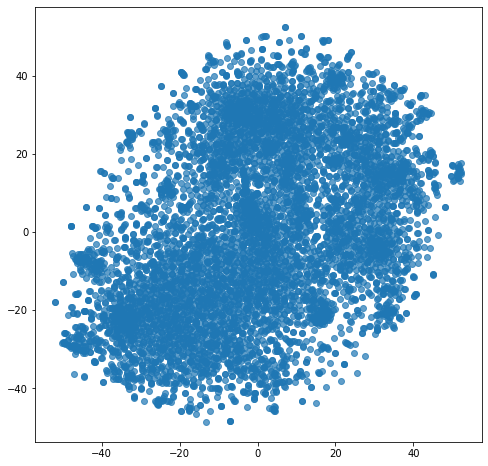

In [28]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state = 0)
new_arr = tsne.fit_transform(arr)

fig, ax = plt.subplots(1,1, figsize=(8, 8))

ax.scatter(new_arr[:, 0], new_arr[:, 1], alpha = 0.7)

plt.show()